      SISTEMA INTEGRADO DE ANÁLISIS HIDROLÓGICO        

--- [1/4] Cargando Geometría y Análisis Morfométrico ---
✅ Cuenca: Rio Cucuana
   > Área (A):       1872.14 km²
   > Perímetro (P):  275.17 km
   > Índice Gravelius (Kc): 1.793
     (Forma: Rectangular-Alargada - Respuesta lenta, atenúa picos)
   > Rectángulo Equivalente:
     Lado Mayor (L): 122.27 km
     Lado Menor (l): 15.31 km

       FASE 1: PRONÓSTICO METEOROLÓGICO (GFS)          
   Conectando al servidor NOAA/Unidata...
   ✅ Datos GFS descargados.

   >>> REPORTE DE PRONÓSTICO METEOROLÓGICO <<<
   Horas      | Ppt Media (mm)  | Caudal Est. (m³/s)   | Volumen (Millones m³)
   --------------------------------------------------------------------------------
   24         | 14.04 mm        | 197.68 m³/s           | 17.08 Hm³
   48         | 24.73 mm        | 174.12 m³/s           | 30.09 Hm³
   72         | 31.43 mm        | 147.55 m³/s           | 38.24 Hm³


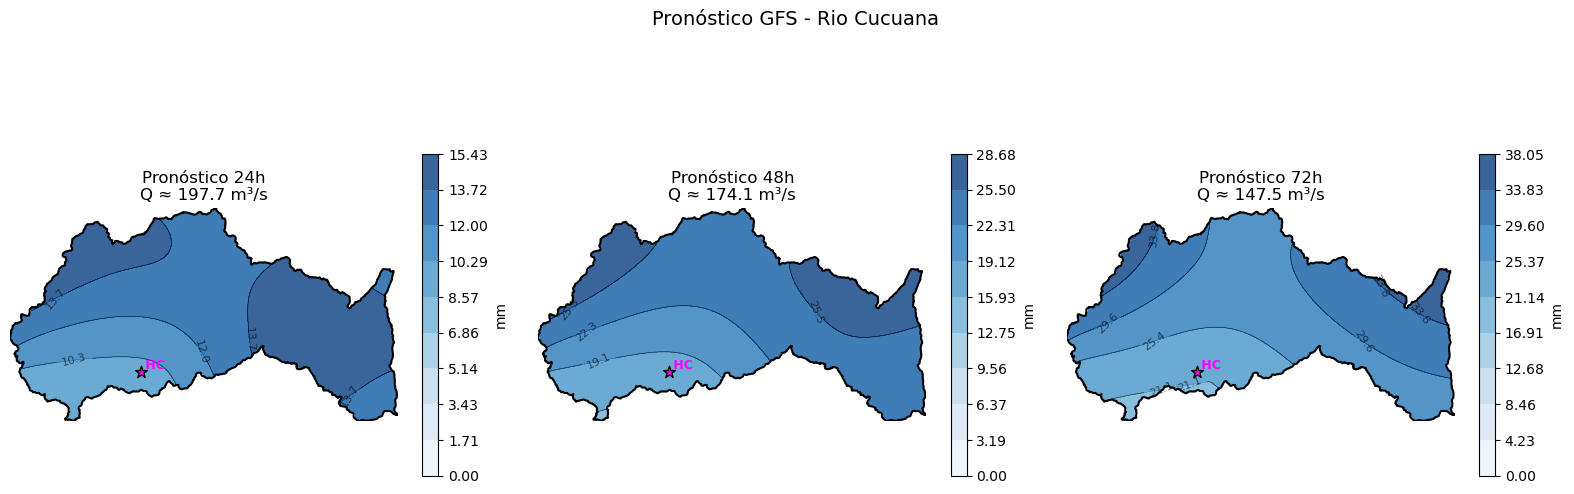


       FASE 2: ANÁLISIS HISTÓRICO (ESTADÍSTICA)        
   Procesando archivos CSV locales...

   >>> REPORTE ESTADÍSTICO HISTÓRICO <<<
   > Tendencia Central y Dispersión:
     N Datos: 1448
     Media:   156.62 mm
     Mediana: 130.55 mm
     Desv.Std:118.69 mm
     CV:      75.8% (Coeficiente de Variación)
     Rangos:  Q1=74.0, Q3=209.6 (IQR=135.7)

   > Análisis de Probabilidad (Gamma):
     Parámetros: Alpha=1.84, Scale=88.15
     Prueba K-S: D=0.0356, p-valor=0.0521
     ✅ Se ajusta a distribución Gamma.

   > Análisis de Cambio (70% vs 30%):
     Media 70%: 161.8 mm | Media 30%: 144.6 mm
     Prueba T: t=2.73, p=0.0065
     ❗ Cambio significativo detectado.


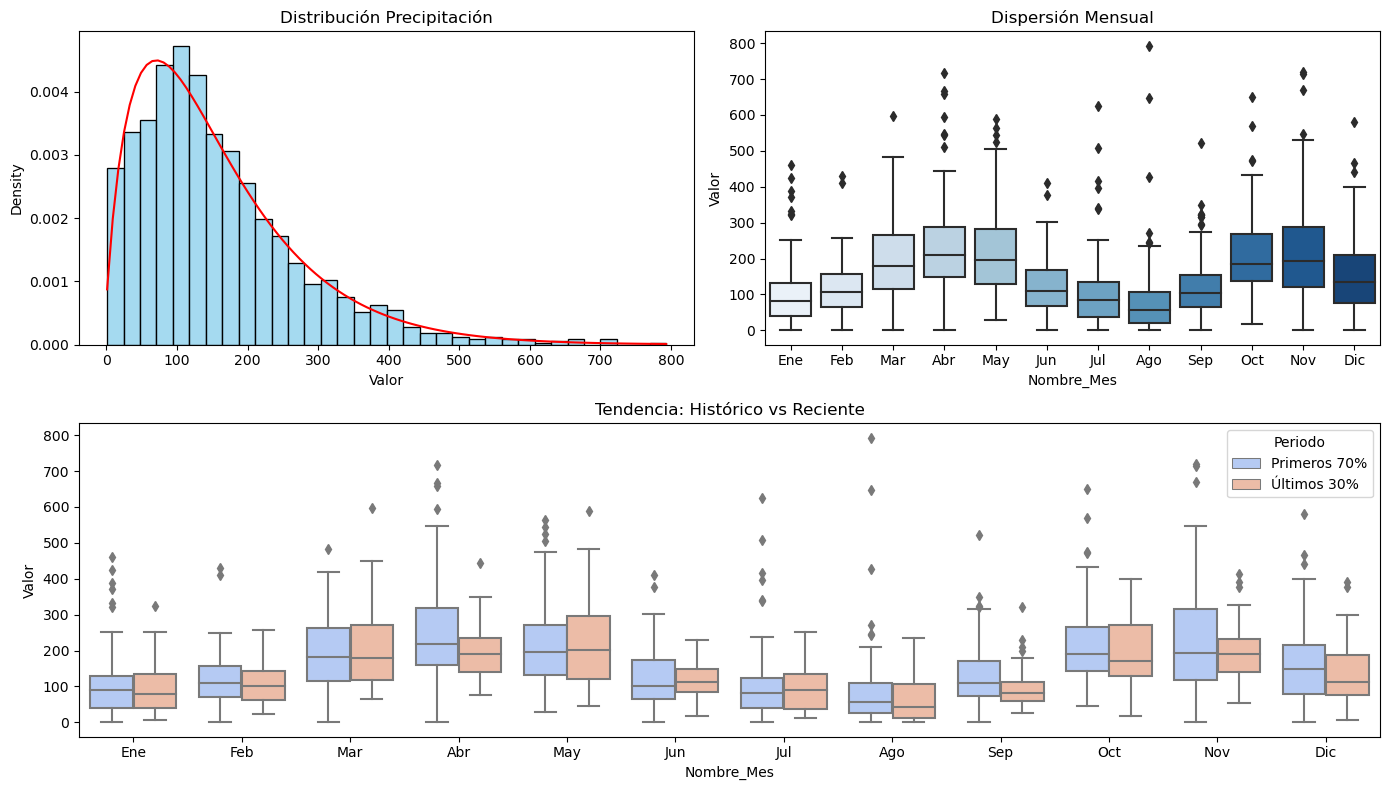


   Generando mapas mensuales históricos...


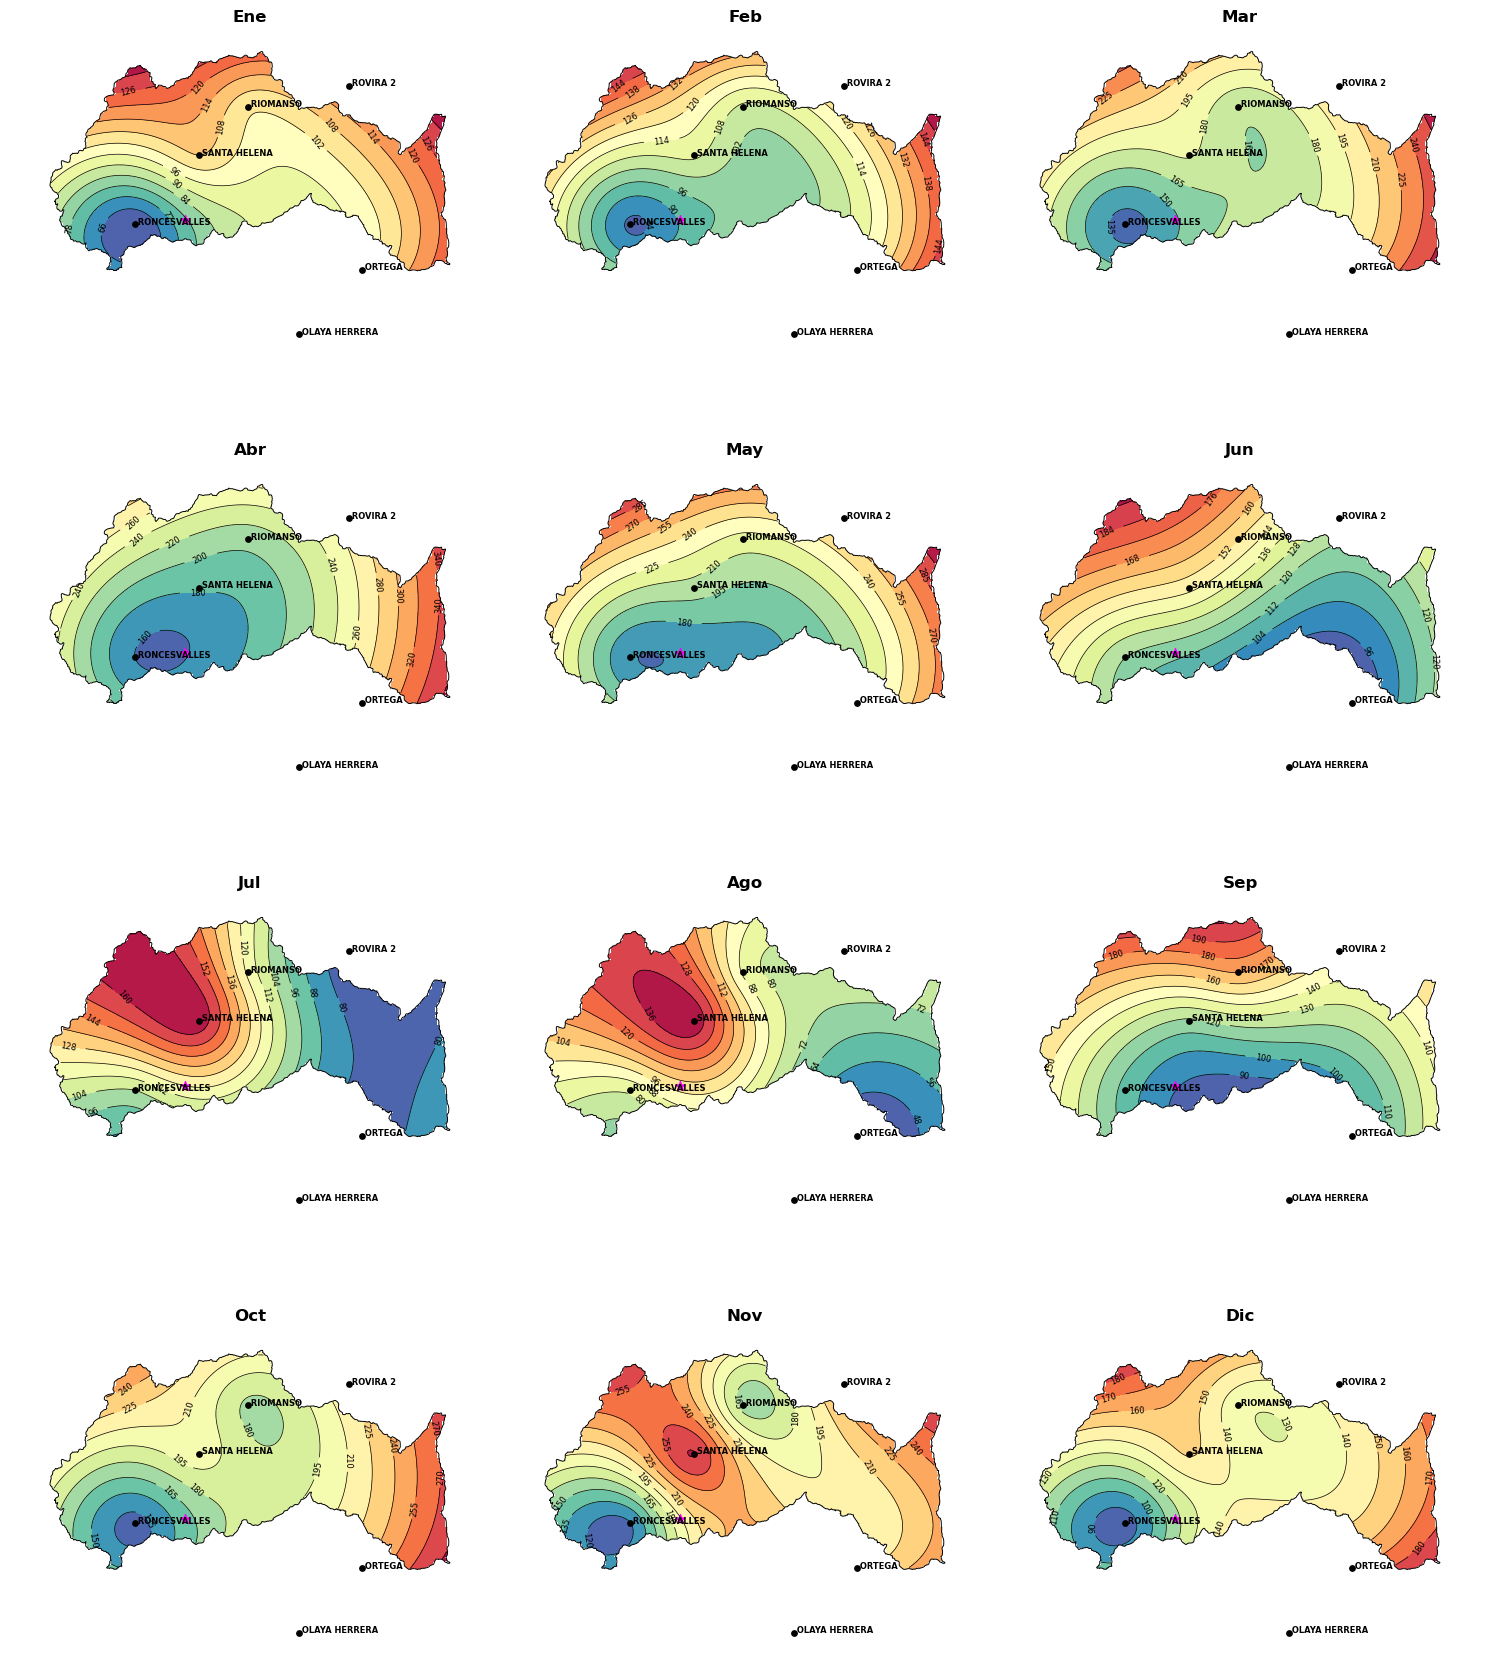


       FASE 3: MODELACIÓN HIDROLÓGICA (ABCD + TH)      

   >>> REPORTE HIDROLÓGICO (BALANCE ABCD + THORNTHWAITE) <<<
   Archivos guardados en: C:\Users\masan\OneDrive\Documentos\Maestria Meteo\2025-II\HIDROMETEOROLOGIA\Cuenca\Resultados_Hidrologicos

   ------------------------------------------------------------
   ESTACIÓN: ROVIRA 2 (IM=108.7)
   ------------------------------------------------------------
   [RESUMEN ANUAL]
     Precipitación Total:    2076.8 mm
     Evapotranspiración Pot: 994.9 mm
     Caudal Simulado Total:  1280.1 mm
     Coef. Escorrentía (Q/P): 0.62
     Índice Flujo Base (Qb/Q): 0.40

   [DETALLE MENSUAL - mm]
     MES   | P        | PET      | Q_Total  | Q_Base   | Estado
     ------------------------------------------------------------
     Ene   | 123.5    | 102.2    | 74.1     | 40.5     | Superávit
     Feb   | 132.6    | 91.1     | 70.6     | 37.4     | Superávit
     Mar   | 217.3    | 96.8     | 122.0    | 40.3     | Superávit
     Abr   | 275.4    

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy.interpolate import Rbf
from scipy import stats
from matplotlib.path import Path
import os
from pathlib import Path as PathLib
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings("ignore")

# =============================================================================
# 1. CONFIGURACIÓN GENERAL DEL SISTEMA
# =============================================================================

# --- RUTAS Y GEOMETRÍA ---
RUTA_SHP = r'\Datos_Estaciones\Subzonas_Hidrográficas_del_Departamento_del_Tolima.shp'
NOMBRE_COLUMNA_SHP = 'SUBZONA_HI'
NOMBRE_CUENCA_OBJETIVO = 'Rio Cucuana'
FOLDER_PATH_ESTACIONES = r'\HIDROMETEOROLOGIA\Cuenca\Estaciones pluvio'

# --- PARÁMETROS HIDROLÓGICOS (ABCD & THORNTHWAITE) ---
COEF_ESCORRENTIA = 0.65 # Para método racional simple (GFS)
CAPACIDAD_CAMPO_THORNTHWAITE = 100.0  # mm

# Parámetros Modelo ABCD:
PARAMETROS_ABCD = {'a': 0.98, 'b': 250.0, 'c': 0.4, 'd': 0.2}

# --- FILTROS TEMPORALES ---
FILTRAR_FECHA_HIST = True
FECHA_INICIO_HIST = '2000-01-01'  
FECHA_FIN_HIST = '2020-12-31'     

# --- PUNTO DE INTERÉS ESPECIAL (HC) ---
PUNTO_HC = {'Label': 'HC', 'Lat': 4.013845092112279, 'Lon': -75.52298732776764}

# --- DATOS GFS ---
GFS_URL = 'https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p25deg/Best'

# --- DICCIONARIO MAESTRO DE ESTACIONES (Ubicación + Temperatura Mensual) ---
estaciones_info = {
  "22075030": { "NOMBRE": "RIOMANSO", "LATITUD": 4.206777778, "LONGITUD": -75.41558333,
    "TEMP_MENSUAL": [25.3, 25.1, 24.6, 23.8, 22.9, 21.5, 21.1, 21.7, 22.4, 23.2, 22.7, 24.1]},
  "22060090": { "NOMBRE": "OLAYA HERRERA", "LATITUD": 3.81989, "LONGITUD": -75.3284,
    "TEMP_MENSUAL": [28.7, 28.4, 27.9, 27.1, 26.2, 25.0, 24.7, 25.1, 26.0, 26.8, 25.9, 27.5]},
  "22060070": { "NOMBRE": "ORTEGA", "LATITUD": 3.92929, "LONGITUD": -75.22135,
    "TEMP_MENSUAL": [27.9, 27.6, 27.1, 26.4, 25.3, 24.1, 23.8, 24.3, 25.2, 26.1, 25.5, 26.8]},
  "22070030": { "NOMBRE": "SANTA HELENA", "LATITUD": 4.124555556, "LONGITUD": -75.49952778,
    "TEMP_MENSUAL": [22.8, 22.5, 22.0, 21.3, 20.4, 19.2, 18.7, 19.4, 20.1, 21.0, 20.6, 21.8]},
  "21180040": { "NOMBRE": "ROVIRA 2", "LATITUD": 4.2425, "LONGITUD": -75.2425,
    "TEMP_MENSUAL": [23.4, 23.1, 22.7, 21.8, 21.0, 19.9, 19.4, 20.0, 20.7, 21.5, 21.2, 22.6]},
  "22070010": { "NOMBRE": "RONCESVALLES", "LATITUD": 4.006638889, "LONGITUD": -75.60775,
    "TEMP_MENSUAL": [18.4, 18.1, 17.7, 17.1, 16.4, 15.8, 15.6, 16.0, 16.5, 17.2, 17.0, 17.9]}
}
NOMBRES_MESES = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

def main():
    print("=======================================================")
    print("      SISTEMA INTEGRADO DE ANÁLISIS HIDROLÓGICO        ")
    print("=======================================================")

    # 1. CARGAR GEOMETRÍA Y MORFOMETRÍA
    print("\n--- [1/4] Cargando Geometría y Análisis Morfométrico ---")
    if not os.path.exists(RUTA_SHP):
        print(f"❌ ERROR CRÍTICO: No se encontró el archivo SHP en:\n{RUTA_SHP}")
        return

    try:
        gdf_raw = gpd.read_file(RUTA_SHP)
        if NOMBRE_COLUMNA_SHP in gdf_raw.columns:
            gdf_cuenca = gdf_raw[gdf_raw[NOMBRE_COLUMNA_SHP] == NOMBRE_CUENCA_OBJETIVO].copy()
            if gdf_cuenca.empty: gdf_cuenca = gdf_raw
        else:
            gdf_cuenca = gdf_raw

        # Proyección métrica para cálculos
        gdf_metros = gdf_cuenca.to_crs(epsg=3116) 
        
        # --- ANÁLISIS MORFOMÉTRICO ---
        area_m2 = gdf_metros.area.sum()
        perimetro_m = gdf_metros.length.sum()
        
        # 1. Índice de Compacidad (Gravelius)
        kc = 0.282 * perimetro_m / np.sqrt(area_m2)
        
        # 2. Rectángulo Equivalente
        term_raiz = 1 - (1.128 / kc)**2
        if term_raiz < 0: term_raiz = 0
        
        L_eq = (kc * np.sqrt(area_m2) / 1.128) * (1 + np.sqrt(term_raiz))
        l_eq = (kc * np.sqrt(area_m2) / 1.128) * (1 - np.sqrt(term_raiz))
        
        print(f"✅ Cuenca: {NOMBRE_CUENCA_OBJETIVO}")
        print(f"   > Área (A):       {area_m2/1e6:.2f} km²")
        print(f"   > Perímetro (P):  {perimetro_m/1e3:.2f} km")
        print(f"   > Índice Gravelius (Kc): {kc:.3f}")
        if kc < 1.25: print("     (Forma: Redonda a Ovalada - Respuesta rápida a lluvias)")
        elif kc < 1.5: print("     (Forma: Ovalada-Oblonga)")
        else: print("     (Forma: Rectangular-Alargada - Respuesta lenta, atenúa picos)")
            
        print(f"   > Rectángulo Equivalente:")
        print(f"     Lado Mayor (L): {L_eq/1e3:.2f} km")
        print(f"     Lado Menor (l): {l_eq/1e3:.2f} km")

        gdf_cuenca = gdf_cuenca.to_crs(epsg=4326) # WGS84 para mapas
        bounds = gdf_cuenca.total_bounds
        min_lon, min_lat, max_lon, max_lat = bounds

    except Exception as e:
        print(f"❌ Error leyendo el Shapefile o calculando morfometría: {e}")
        return

    # 2. FASE 1: PRONÓSTICO GFS
    print("\n=======================================================")
    print("       FASE 1: PRONÓSTICO METEOROLÓGICO (GFS)          ")
    print("=======================================================")
    ejecutar_pronostico_gfs(gdf_cuenca, area_m2, min_lon, max_lon, min_lat, max_lat)

    # 3. FASE 2: ANÁLISIS HISTÓRICO (RETORNA DATOS PARA FASE 3)
    print("\n=======================================================")
    print("       FASE 2: ANÁLISIS HISTÓRICO (ESTADÍSTICA)        ")
    print("=======================================================")
    df_historico = None
    if os.path.exists(FOLDER_PATH_ESTACIONES):
        df_historico = ejecutar_analisis_historico(gdf_cuenca, area_m2, bounds)
    else:
        print(f"⚠️ No se encontró carpeta estaciones.")

    # 4. FASE 3: BALANCE HÍDRICO ABCD
    print("\n=======================================================")
    print("       FASE 3: MODELACIÓN HIDROLÓGICA (ABCD + TH)      ")
    print("=======================================================")
    if df_historico is not None:
        ejecutar_balance_abcd(df_historico)
    else:
        print("❌ No hay datos históricos para ejecutar el balance hídrico.")


# =============================================================================
# FUNCIONES FASE 1: PRONÓSTICO GFS
# =============================================================================
def ejecutar_pronostico_gfs(gdf_cuenca, AREA_M2, min_lon, max_lon, min_lat, max_lat):
    print("   Conectando al servidor NOAA/Unidata...")
    try:
        ds = xr.open_dataset(GFS_URL, engine='netcdf4')
        
        buffer = 0.5
        lat_slice = slice(max_lat + buffer, min_lat - buffer)
        lon_min_360 = (min_lon - buffer) % 360
        lon_max_360 = (max_lon + buffer) % 360
        lon_slice = slice(lon_min_360, lon_max_360)

        t_start = datetime.utcnow()
        t_end = t_start + timedelta(hours=72)
        var_name = 'Precipitation_rate_surface'
        
        if var_name not in ds.variables:
            posibles = [v for v in ds.variables if 'Precipitation' in v and 'surface' in v]
            if posibles: var_name = posibles[0]
            else: raise ValueError("Variable precipitación no encontrada en GFS")

        # Detección dinámica tiempo
        dims_list = list(ds[var_name].dims)
        name_time = next((d for d in dims_list if 'time' in d.lower() or 'valid' in d.lower()), 'time')
        name_lat = next((d for d in dims_list if 'lat' in d.lower()), 'lat')
        name_lon = next((d for d in dims_list if 'lon' in d.lower()), 'lon')

        selection = {name_lat: lat_slice, name_lon: lon_slice, name_time: slice(t_start, t_end)}
        data = ds[var_name].sel(**selection).load()

        rename_dict = {}
        if name_time != 'time': rename_dict[name_time] = 'time'
        if name_lat != 'lat': rename_dict[name_lat] = 'lat'
        if name_lon != 'lon': rename_dict[name_lon] = 'lon'
        if rename_dict: data = data.rename(rename_dict)
        
        data.coords['lon'] = (data.coords['lon'] + 180) % 360 - 180
        data = data.sortby('lon')
        print("   ✅ Datos GFS descargados.")

        horizontes = [24, 48, 72]
        fig, axes = plt.subplots(1, 3, figsize=(16, 6))
        
        grid_x, grid_y = np.meshgrid(np.linspace(min_lon, max_lon, 200), np.linspace(min_lat, max_lat, 200))
        mask = crear_mascara(gdf_cuenca, grid_x, grid_y)

        # REPORTE DE PRONÓSTICO
        print("\n   >>> REPORTE DE PRONÓSTICO METEOROLÓGICO <<<")
        print(f"   {'Horas':<10} | {'Ppt Media (mm)':<15} | {'Caudal Est. (m³/s)':<20} | {'Volumen (Millones m³)'}")
        print("   " + "-" * 80)

        for i, h in enumerate(horizontes):
            try:
                t_fin = data.time[0] + np.timedelta64(h, 'h')
                if t_fin > data.time[-1]: t_fin = data.time[-1]
                
                slice_h = data.sel(time=slice(data.time[0], t_fin))
                if slice_h.time.size == 0: continue

                tasa_media = slice_h.mean(dim='time')
                acumulado_mm = tasa_media * (h * 3600)
                
                media_espacial = acumulado_mm.mean().item()
                # Caudal Medio = (Ppt / tiempo) * Area * C
                q_est = (media_espacial / 1000.0 / (h * 3600)) * AREA_M2 * COEF_ESCORRENTIA
                vol_est_hm3 = (media_espacial / 1000.0) * AREA_M2 * COEF_ESCORRENTIA / 1e6
                
                print(f"   {h:<10} | {media_espacial:.2f} mm        | {q_est:.2f} m³/s           | {vol_est_hm3:.2f} Hm³")

                ax = axes[i]
                lats_g, lons_g = np.meshgrid(acumulado_mm.lat, acumulado_mm.lon, indexing='ij')
                
                rbf = Rbf(lons_g.flatten(), lats_g.flatten(), acumulado_mm.values.flatten(), function='linear')
                grid_z = rbf(grid_x, grid_y)
                grid_z[grid_z < 0] = 0 
                grid_z[~mask] = np.nan
                
                niveles = np.linspace(0, max(np.nanmax(grid_z), 1.0), 10)
                cf = ax.contourf(grid_x, grid_y, grid_z, levels=niveles, cmap='Blues', alpha=0.8)
                cs = ax.contour(grid_x, grid_y, grid_z, levels=niveles, colors='black', linewidths=0.5, alpha=0.6)
                ax.clabel(cs, inline=True, fontsize=8, fmt='%1.1f')

                gdf_cuenca.plot(ax=ax, facecolor='none', edgecolor='black', lw=1.5)
                
                # PUNTO HC
                ax.scatter(PUNTO_HC['Lon'], PUNTO_HC['Lat'], c='magenta', s=80, marker='*', edgecolors='black', zorder=10)
                ax.text(PUNTO_HC['Lon'], PUNTO_HC['Lat'], f" {PUNTO_HC['Label']}", color='magenta', fontsize=9, fontweight='bold', ha='left', va='bottom')
                
                ax.set_title(f"Pronóstico {h}h\nQ ≈ {q_est:.1f} m³/s")
                ax.axis('off')
                plt.colorbar(cf, ax=ax, shrink=0.6, label='mm')

            except Exception as e: pass

        plt.suptitle(f"Pronóstico GFS - {NOMBRE_CUENCA_OBJETIVO}", fontsize=14)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Error en GFS: {e}")


# =============================================================================
# FUNCIONES FASE 2: ANÁLISIS HISTÓRICO
# =============================================================================
def ejecutar_analisis_historico(gdf_cuenca, AREA_M2, bounds):
    print("   Procesando archivos CSV locales...")
    margin_x = (bounds[2] - bounds[0]) * 0.1
    margin_y = (bounds[3] - bounds[1]) * 0.1
    xlim_min, ylim_min = bounds[0] - margin_x, bounds[1] - margin_y
    xlim_max, ylim_max = bounds[2] + margin_x, bounds[3] + margin_y

    csv_files = [f for f in os.listdir(FOLDER_PATH_ESTACIONES) if f.endswith('.csv')]
    data_frames = []

    for file in csv_files:
        station_id = file.split('@')[1].split('.')[0] if '@' in file else file.replace('.csv', '')
        if station_id not in estaciones_info: continue

        try:
            df = pd.read_csv(os.path.join(FOLDER_PATH_ESTACIONES, file), skiprows=14, encoding='latin-1', sep=',')
            df.columns = df.columns.str.strip()
            if 'Value' in df.columns:
                df['Fecha'] = pd.to_datetime(df['Timestamp (UTC-05:00)'], errors='coerce')
                df['Valor'] = pd.to_numeric(df['Value'], errors='coerce')
                if FILTRAR_FECHA_HIST:
                    df = df[(df['Fecha'] >= FECHA_INICIO_HIST) & (df['Fecha'] <= FECHA_FIN_HIST)]
                
                df['Estacion'] = station_id
                df['Mes'] = df['Fecha'].dt.month
                df['Anio'] = df['Fecha'].dt.year
                data_frames.append(df[['Fecha', 'Anio', 'Mes', 'Valor', 'Estacion']])
        except: pass

    if not data_frames:
        print("❌ No se encontraron datos históricos válidos.")
        return None

    df_all = pd.concat(data_frames)
    df_mensual_historico = df_all.groupby(['Estacion', 'Anio', 'Mes'])['Valor'].sum().reset_index()
    df_mensual_historico['Fecha'] = pd.to_datetime(df_mensual_historico.apply(lambda x: f"{int(x.Anio)}-{int(x.Mes)}-01", axis=1))
    
    df_mensual_historico['Nombre_Est'] = df_mensual_historico['Estacion'].apply(lambda x: estaciones_info[x]['NOMBRE'])
    df_mensual_historico['Nombre_Mes'] = df_mensual_historico['Mes'].apply(lambda x: NOMBRES_MESES[x-1])

    # --- REPORTE ESTADÍSTICO DETALLADO ---
    print("\n   >>> REPORTE ESTADÍSTICO HISTÓRICO <<<")
    serie_total = df_mensual_historico['Valor']
    
    print(f"   > Tendencia Central y Dispersión:")
    print(f"     N Datos: {len(serie_total)}")
    print(f"     Media:   {serie_total.mean():.2f} mm")
    print(f"     Mediana: {serie_total.median():.2f} mm")
    print(f"     Desv.Std:{serie_total.std():.2f} mm")
    print(f"     CV:      {(serie_total.std()/serie_total.mean())*100:.1f}% (Coeficiente de Variación)")
    print(f"     Rangos:  Q1={serie_total.quantile(0.25):.1f}, Q3={serie_total.quantile(0.75):.1f} (IQR={serie_total.quantile(0.75)-serie_total.quantile(0.25):.1f})")

    # K-S Test Gamma
    datos_pos = serie_total[serie_total > 0]
    shape, loc, scale = stats.gamma.fit(datos_pos)
    ks_stat, p_value = stats.kstest(datos_pos, 'gamma', args=(shape, loc, scale))
    print(f"\n   > Análisis de Probabilidad (Gamma):")
    print(f"     Parámetros: Alpha={shape:.2f}, Scale={scale:.2f}")
    print(f"     Prueba K-S: D={ks_stat:.4f}, p-valor={p_value:.4f}")
    if p_value > 0.05: print("     ✅ Se ajusta a distribución Gamma.")
    else: print("     ⚠️ No se ajusta estrictamente a Gamma.")

    # Tendencia
    df_ordenado = df_mensual_historico.sort_values('Fecha')
    n_70 = int(len(df_ordenado) * 0.7)
    s70 = df_ordenado.iloc[:n_70]['Valor']
    s30 = df_ordenado.iloc[n_70:]['Valor']
    t_stat, p_val_t = stats.ttest_ind(s70, s30, equal_var=False)
    
    print(f"\n   > Análisis de Cambio (70% vs 30%):")
    print(f"     Media 70%: {s70.mean():.1f} mm | Media 30%: {s30.mean():.1f} mm")
    print(f"     Prueba T: t={t_stat:.2f}, p={p_val_t:.4f}")
    if p_val_t < 0.05: print("     ❗ Cambio significativo detectado.")
    else: print("     ℹ️ Sin cambio significativo.")

    # Gráficos Estadísticos
    fig_stats = plt.figure(figsize=(14, 8))
    gs = fig_stats.add_gridspec(2, 2)
    ax1 = fig_stats.add_subplot(gs[0, 0])
    sns.histplot(datos_pos, kde=False, stat="density", color="skyblue", ax=ax1)
    x = np.linspace(datos_pos.min(), datos_pos.max(), 100)
    ax1.plot(x, stats.gamma.pdf(x, shape, loc, scale), 'r-', label='Gamma')
    ax1.set_title("Distribución Precipitación")
    
    ax2 = fig_stats.add_subplot(gs[0, 1])
    sns.boxplot(data=df_mensual_historico, x='Nombre_Mes', y='Valor', palette='Blues', ax=ax2)
    ax2.set_title('Dispersión Mensual')

    # Split 70/30
    df_ordenado['Periodo'] = 'Primeros 70%'
    df_ordenado.iloc[n_70:, df_ordenado.columns.get_loc('Periodo')] = 'Últimos 30%'
    ax3 = fig_stats.add_subplot(gs[1, :])
    sns.boxplot(data=df_ordenado, x='Nombre_Mes', y='Valor', hue='Periodo', ax=ax3, palette='coolwarm')
    ax3.set_title('Tendencia: Histórico vs Reciente')
    plt.tight_layout()
    plt.show()

    # --- MAPAS ---
    print("\n   Generando mapas mensuales históricos...")
    grid_x, grid_y = np.meshgrid(np.linspace(xlim_min, xlim_max, 200), np.linspace(ylim_min, ylim_max, 200))
    mask = crear_mascara(gdf_cuenca, grid_x, grid_y)
    df_mapas = df_mensual_historico.groupby(['Estacion', 'Mes'])['Valor'].mean().reset_index()
    df_mapas['Lat'] = df_mapas['Estacion'].apply(lambda x: estaciones_info[x]['LATITUD'])
    df_mapas['Lon'] = df_mapas['Estacion'].apply(lambda x: estaciones_info[x]['LONGITUD'])
    df_mapas['Nombre'] = df_mapas['Estacion'].apply(lambda x: estaciones_info[x]['NOMBRE'])

    fig, axes = plt.subplots(4, 3, figsize=(15, 18))
    axes = axes.flatten()
    for mes in range(1, 13):
        ax = axes[mes-1]
        df_m = df_mapas[df_mapas['Mes'] == mes]
        if len(df_m) < 3: continue
        try:
            rbf = Rbf(df_m['Lon'], df_m['Lat'], df_m['Valor'], function='thin_plate')
            grid_z = rbf(grid_x, grid_y)
            grid_z[grid_z < 0] = 0
            grid_z[~mask] = np.nan
            
            cf = ax.contourf(grid_x, grid_y, grid_z, levels=12, cmap='Spectral_r')
            cs = ax.contour(grid_x, grid_y, grid_z, levels=12, colors='black', linewidths=0.5)
            ax.clabel(cs, inline=True, fontsize=6, fmt='%1.0f')
            gdf_cuenca.plot(ax=ax, facecolor='none', edgecolor='black', lw=0.7)
            
            # Estaciones
            ax.scatter(df_m['Lon'], df_m['Lat'], c='black', s=15)
            for _, r in df_m.iterrows():
                ax.text(r['Lon'], r['Lat'], f" {r['Nombre']}", fontsize=6, fontweight='bold', ha='left')
            
            # Punto HC
            ax.scatter(PUNTO_HC['Lon'], PUNTO_HC['Lat'], c='magenta', s=50, marker='*')
            
            ax.set_title(NOMBRES_MESES[mes-1], fontweight='bold')
            ax.axis('off')
        except: pass
    plt.tight_layout()
    plt.show()
    
    return df_mensual_historico

# =============================================================================
# FUNCIONES FASE 3: BALANCE HÍDRICO ABCD + THORNTHWAITE
# =============================================================================
def ejecutar_balance_abcd(df_historico):
    out_dir = PathLib(FOLDER_PATH_ESTACIONES).parent / "Resultados_Hidrologicos"
    out_dir.mkdir(exist_ok=True)
    print(f"\n   >>> REPORTE HIDROLÓGICO (BALANCE ABCD + THORNTHWAITE) <<<")
    print(f"   Archivos guardados en: {out_dir}")

    # Climatología Mensual P (Promedio multianual por estación y mes)
    df_climatologia = df_historico.groupby(['Estacion', 'Mes'])['Valor'].mean().reset_index()

    estaciones_con_datos = df_climatologia['Estacion'].unique()
    
    for cod in estaciones_con_datos:
        if cod not in estaciones_info: continue
        info = estaciones_info[cod]
        nombre = info['NOMBRE']
        
        # Series de P y T para este punto
        P_med = df_climatologia[df_climatologia['Estacion'] == cod].sort_values('Mes')['Valor'].values
        if len(P_med) != 12: 
            P_med = np.pad(P_med, (0, 12-len(P_med)), 'constant') # Rellenar si falta
            
        T_med = np.array(info['TEMP_MENSUAL'])
        
        # Ejecutar Núcleo de Modelación
        df_res = nucleo_abcd_thornthwaite(P_med, T_med, info['LATITUD'])
        
        # Índices Climáticos
        im_val = (100 * df_res['TH_Exc'].sum() - 60 * df_res['TH_Def'].sum()) / df_res['PET_mm'].sum()
        
        # --- IMPRIMIR REPORTE POR ESTACIÓN ---
        print(f"\n   ------------------------------------------------------------")
        print(f"   ESTACIÓN: {nombre} (IM={im_val:.1f})")
        print(f"   ------------------------------------------------------------")
        
        # Totales Anuales
        p_anual = df_res['P_mm'].sum()
        pet_anual = df_res['PET_mm'].sum()
        q_anual = df_res['Q_Total'].sum()
        q_base_anual = df_res['Q_Base'].sum()
        
        print(f"   [RESUMEN ANUAL]")
        print(f"     Precipitación Total:    {p_anual:.1f} mm")
        print(f"     Evapotranspiración Pot: {pet_anual:.1f} mm")
        print(f"     Caudal Simulado Total:  {q_anual:.1f} mm")
        print(f"     Coef. Escorrentía (Q/P): {(q_anual/p_anual):.2f}")
        print(f"     Índice Flujo Base (Qb/Q): {(q_base_anual/q_anual):.2f}")
        
        # Tabla Mensual en Consola
        print(f"\n   [DETALLE MENSUAL - mm]")
        print(f"     {'MES':<5} | {'P':<8} | {'PET':<8} | {'Q_Total':<8} | {'Q_Base':<8} | {'Estado'}")
        print(f"     " + "-"*60)
        for idx, row in df_res.iterrows():
            estado = "Superávit" if row['P_mm'] > row['PET_mm'] else "Déficit"
            print(f"     {NOMBRES_MESES[idx]:<5} | {row['P_mm']:<8.1f} | {row['PET_mm']:<8.1f} | {row['Q_Total']:<8.1f} | {row['Q_Base']:<8.1f} | {estado}")

        # Guardar CSV
        df_res.round(2).to_csv(out_dir / f"Balance_{nombre}.csv", index=False)
        
        # Graficar
        graficar_balance_caudal(df_res, nombre, im_val, out_dir / f"Hidrograma_{nombre}.png")

def nucleo_abcd_thornthwaite(P_med, T_med, latitud):
    # Setup
    df = pd.DataFrame({'Mes_Num': range(1,13), 'P_mm': P_med, 'T_C': T_med})
    
    # 1. THORNTHWAITE PET
    I = np.sum((T_med / 5) ** 1.514)
    a_th = (6.75e-7 * I**3) - (7.71e-5 * I**2) + (1.792e-2 * I) + 0.49239
    
    # Factor Latitud
    def f_lat(mes, lat):
        dias = [0, 31, 28.25, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        phi = np.radians(lat)
        delta = 0.409 * np.sin(2 * np.pi * mes / 12 - 1.39)
        try: omega = np.arccos(-np.tan(phi) * np.tan(delta))
        except: omega = 0
        N = 24 / np.pi * omega
        return (N / 12) * (dias[mes] / 30)

    df['PET_mm'] = 16 * ((10 * df['T_C']) / I) ** a_th
    df['PET_mm'] *= df['Mes_Num'].apply(lambda x: f_lat(x, latitud))

    # 2. BALANCE THORNTHWAITE (Clásico)
    cap = CAPACIDAD_CAMPO_THORNTHWAITE
    alm = cap
    th_exc, th_def = [], []
    
    # Warmup
    for _ in range(2):
        for i in range(12):
            diff = df.loc[i, 'P_mm'] - df.loc[i, 'PET_mm']
            alm = min(max(alm + diff, 0), cap)
            
    for i in range(12):
        diff = df.loc[i, 'P_mm'] - df.loc[i, 'PET_mm']
        nuevo_alm = min(max(alm + diff, 0), cap)
        delta = nuevo_alm - alm
        if diff >= 0:
            th_exc.append(diff - delta)
            th_def.append(0)
        else:
            th_exc.append(0)
            th_def.append(df.loc[i, 'PET_mm'] - (df.loc[i, 'P_mm'] + abs(delta)))
        alm = nuevo_alm
    
    df['TH_Exc'] = th_exc
    df['TH_Def'] = th_def

    # 3. MODELO ABCD (Caudales)
    a, b, c, d = PARAMETROS_ABCD.values()
    S, G = b/2, 100 # Estados iniciales
    
    # Warmup ABCD
    for _ in range(3):
        for i in range(12):
            W = df.loc[i, 'P_mm'] + S
            Y = (W + b) / (2 * a) - np.sqrt(((W + b) / (2 * a))**2 - (W * b) / a)
            S = Y * np.exp(-df.loc[i, 'PET_mm'] / b)
            G = (c * (W - Y) + G) / (1 + d)

    q_total, q_base = [], []
    for i in range(12):
        W = df.loc[i, 'P_mm'] + S
        Y = (W + b) / (2 * a) - np.sqrt(((W + b) / (2 * a))**2 - (W * b) / a)
        S_new = Y * np.exp(-df.loc[i, 'PET_mm'] / b)
        avail = W - Y
        G_new = (c * avail + G) / (1 + d)
        
        Q_bas = d * G_new
        Q_dir = (1 - c) * avail
        
        q_total.append(Q_dir + Q_bas)
        q_base.append(Q_bas)
        S, G = S_new, G_new
        
    df['Q_Total'] = q_total
    df['Q_Base'] = q_base
    return df

def graficar_balance_caudal(df, nombre, im, path):
    fig, ax = plt.subplots(figsize=(10, 6))
    x = range(1, 13)
    # Balance Climático
    ax.fill_between(x, df['P_mm'], df['PET_mm'], where=(df['P_mm']>df['PET_mm']), color='blue', alpha=0.1, label='Exceso Climático')
    ax.fill_between(x, df['P_mm'], df['PET_mm'], where=(df['P_mm']<=df['PET_mm']), color='red', alpha=0.1, label='Déficit Climático')
    
    ax.plot(x, df['P_mm'], 'b-o', lw=1.5, label='Precipitación')
    ax.plot(x, df['PET_mm'], 'r--', label='Evapotranspiración (PET)')
    
    # Caudales ABCD
    ax.plot(x, df['Q_Total'], 'k-', lw=2.5, label='Caudal Simulado (ABCD)')
    ax.plot(x, df['Q_Base'], 'k:', label='Flujo Base')
    
    ax.set_title(f"Balance Hídrico y Caudales: {nombre} (Im={im:.1f})")
    ax.set_xticks(x)
    ax.set_xticklabels(NOMBRES_MESES)
    ax.set_ylabel("mm")
    ax.legend(ncol=2)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(path)
    plt.close()

def crear_mascara(gdf, gx, gy):
    poly_union = gdf.unary_union
    points = np.vstack((gx.flatten(), gy.flatten())).T
    if hasattr(poly_union, 'geoms'):
        mask = np.zeros(gx.shape, dtype=bool).flatten()
        for poly in poly_union.geoms:
            mask = mask | Path(np.array(poly.exterior.coords)).contains_points(points)
    else:
        mask = Path(np.array(poly_union.exterior.coords)).contains_points(points)
    return mask.reshape(gx.shape)

if __name__ == "__main__":
    main()

In [ ]:
"""
balance_hidrico_multianual_v3_abcd.py

Genera el BALANCE HÍDRICO MENSUAL MULTIANUAL + MODELO DE CAUDALES ABCD.

1. Calcula Climatología (Promedio Ene-Dic) de Precipitación.
2. Calcula PET usando Thornthwaite.
3. Ejecuta Balance Clásico (Thornthwaite) para Clasificación Climática.
4. Ejecuta Modelo ABCD para estimar Escorrentía Directa y Flujo Base.
5. Genera reportes (Excel/CSV) y gráficos integrados.
"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

# ---------------------------------------------------------
# 1. CONFIGURACIÓN
# ---------------------------------------------------------
FOLDER_PATH = r'HIDROMETEOROLOGIA\Cuenca\Estaciones pluvio'

# Periodo de Análisis
FECHA_INICIO = '2000-01-01'
FECHA_FIN = '2020-12-31'

# Parámetros Thornthwaite
CAPACIDAD_CAMPO_THORNTHWAITE = 100.0  # mm (Para balance de suelos agrícola)

# Parámetros Modelo ABCD (Teóricos - Ajustar si hay datos de caudal)
# a: Propensión a escorrentía (0-1). 0.98 es usual para cuencas con buena infiltración inicial.
# b: Límite superior de almacenamiento (mm). Similar a capacidad de campo pero suele ser mayor.
# c: Factor de recarga subterránea (0-1). Cuanto va al acuífero.
# d: Constante de recesión flujo base (0-1). Inverso del tiempo de residencia.
PARAMETROS_ABCD = {'a': 0.98, 'b': 250.0, 'c': 0.4, 'd': 0.2}

NOMBRES_MESES = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
KEYS_TEMP = ['ENE', 'FEB', 'MAR', 'ABR', 'MAY', 'JUN', 'JUL', 'AGO', 'SEP', 'OCT', 'NOV', 'DIC']

# Diccionario de Estaciones (Temperaturas)
estaciones_info = {
  "22075030": { "NOMBRE": "RIOMANSO", "LATITUD": 4.206777778, "LONGITUD": -75.41558333,
    "TEMP_MENSUAL": {"ENE": 25.3, "FEB": 25.1, "MAR": 24.6, "ABR": 23.8, "MAY": 22.9, "JUN": 21.5, "JUL": 21.1, "AGO": 21.7, "SEP": 22.4, "OCT": 23.2, "NOV": 22.7, "DIC": 24.1}},
  "22060090": { "NOMBRE": "OLAYA HERRERA", "LATITUD": 3.81989, "LONGITUD": -75.3284,
    "TEMP_MENSUAL": {"ENE": 28.7, "FEB": 28.4, "MAR": 27.9, "ABR": 27.1, "MAY": 26.2, "JUN": 25.0, "JUL": 24.7, "AGO": 25.1, "SEP": 26.0, "OCT": 26.8, "NOV": 25.9, "DIC": 27.5}},
  "22060070": { "NOMBRE": "ORTEGA", "LATITUD": 3.92929, "LONGITUD": -75.22135,
    "TEMP_MENSUAL": {"ENE": 27.9, "FEB": 27.6, "MAR": 27.1, "ABR": 26.4, "MAY": 25.3, "JUN": 24.1, "JUL": 23.8, "AGO": 24.3, "SEP": 25.2, "OCT": 26.1, "NOV": 25.5, "DIC": 26.8}},
  "22070030": { "NOMBRE": "SANTA HELENA", "LATITUD": 4.124555556, "LONGITUD": -75.49952778,
    "TEMP_MENSUAL": {"ENE": 22.8, "FEB": 22.5, "MAR": 22.0, "ABR": 21.3, "MAY": 20.4, "JUN": 19.2, "JUL": 18.7, "AGO": 19.4, "SEP": 20.1, "OCT": 21.0, "NOV": 20.6, "DIC": 21.8}},
  "21180040": { "NOMBRE": "ROVIRA 2", "LATITUD": 4.2425, "LONGITUD": -75.2425,
    "TEMP_MENSUAL": {"ENE": 23.4, "FEB": 23.1, "MAR": 22.7, "ABR": 21.8, "MAY": 21.0, "JUN": 19.9, "JUL": 19.4, "AGO": 20.0, "SEP": 20.7, "OCT": 21.5, "NOV": 21.2, "DIC": 22.6}},
  "22070010": { "NOMBRE": "RONCESVALLES", "LATITUD": 4.006638889, "LONGITUD": -75.60775,
    "TEMP_MENSUAL": {"ENE": 18.4, "FEB": 18.1, "MAR": 17.7, "ABR": 17.1, "MAY": 16.4, "JUN": 15.8, "JUL": 15.6, "AGO": 16.0, "SEP": 16.5, "OCT": 17.2, "NOV": 17.0, "DIC": 17.9}}
}

# ---------------------------------------------------------
# 2. FUNCIONES DE LECTURA Y UTILIDADES
# ---------------------------------------------------------
def leer_y_promediar_precipitacion(path):
    """
    Lee histórico, filtra fecha y calcula promedio mensual multianual.
    """
    try:
        try: df = pd.read_csv(path, encoding='utf-8', skiprows=14)
        except: df = pd.read_csv(path, encoding='latin1', skiprows=14)
        
        if df.empty or len(df.columns) < 2:
            df = pd.read_csv(path, encoding='latin1')

        df.columns = df.columns.str.strip()
        
        col_fecha = next((c for c in df.columns if 'fecha' in c.lower() or 'date' in c.lower() or 'timestamp' in c.lower()), None)
        col_valor = next((c for c in df.columns if any(x in c.lower() for x in ['precip', 'valor', 'value', 'rain', 'lluvia'])), None)

        if not col_fecha or not col_valor: return None

        df[col_fecha] = pd.to_datetime(df[col_fecha], errors='coerce')
        df[col_valor] = pd.to_numeric(df[col_valor], errors='coerce')
        df = df.dropna(subset=[col_fecha, col_valor])
        
        df = df[(df[col_fecha] >= FECHA_INICIO) & (df[col_fecha] <= FECHA_FIN)]
        
        df['anio'] = df[col_fecha].dt.year
        df['mes'] = df[col_fecha].dt.month
        
        # Suma mensual por año y luego promedio de esos sumatorios
        mensual_por_anio = df.groupby(['anio', 'mes'])[col_valor].sum().reset_index()
        promedio_climatologico = mensual_por_anio.groupby('mes')[col_valor].mean().sort_index()
        promedio_climatologico = promedio_climatologico.reindex(range(1,13), fill_value=0)
        
        return promedio_climatologico.values
    except Exception as e:
        print(f"  [!] Error leyendo {path.name}: {e}")
        return None

def calcular_factor_latitud(latitud, mes_num):
    dias_mes = [0, 31, 28.25, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    phi = np.radians(latitud)
    delta = 0.409 * np.sin(2 * np.pi * mes_num / 12 - 1.39)
    try:
        omega = np.arccos(-np.tan(phi) * np.tan(delta))
        N = 24 / np.pi * omega
    except: N = 12
    return (N / 12) * (dias_mes[mes_num] / 30)

# ---------------------------------------------------------
# 3. MODELOS HIDROLÓGICOS
# ---------------------------------------------------------

def ejecutar_thornthwaite_y_abcd(P_med, T_med, latitud, cap_th, params_abcd):
    """
    Ejecuta ambos modelos sobre el año promedio climatológico.
    """
    # --- A. PREPARAR DATOS Y PET ---
    df = pd.DataFrame({'Mes_Num': range(1,13), 'Mes': NOMBRES_MESES, 'P_mm': P_med, 'T_C': T_med})
    
    I_anual = np.sum((np.array(T_med) / 5) ** 1.514)
    a_th = (6.75e-7 * I_anual**3) - (7.71e-5 * I_anual**2) + (1.792e-2 * I_anual) + 0.49239
    
    df['Et_raw'] = 16 * ((10 * df['T_C']) / I_anual) ** a_th
    df['F_Lat'] = df['Mes_Num'].apply(lambda x: calcular_factor_latitud(latitud, x))
    df['PET_mm'] = df['Et_raw'] * df['F_Lat']
    
    # --- B. BALANCE THORNTHWAITE (Clásico para Clasificación) ---
    alm_prev = cap_th
    # Calentamiento TH
    for _ in range(3):
        for idx in range(12):
            diff = df.loc[idx, 'P_mm'] - df.loc[idx, 'PET_mm']
            nuevo = min(max(alm_prev + diff, 0), cap_th)
            alm_prev = nuevo
            
    # Ejecución TH
    th_alm, th_etr, th_exc, th_def = [], [], [], []
    for i in range(12):
        diff = df.loc[i, 'P_mm'] - df.loc[i, 'PET_mm']
        nuevo = min(max(alm_prev + diff, 0), cap_th)
        da = nuevo - alm_prev
        
        if diff >= 0:
            etr = df.loc[i, 'PET_mm']
            exc = diff - da
            dft = 0
        else:
            etr = df.loc[i, 'P_mm'] + abs(da)
            exc = 0
            dft = df.loc[i, 'PET_mm'] - etr
            
        th_alm.append(nuevo)
        th_etr.append(etr)
        th_exc.append(exc)
        th_def.append(dft)
        alm_prev = nuevo
        
    df['TH_Alm'] = th_alm
    df['TH_Etr'] = th_etr
    df['TH_Def'] = th_def
    df['TH_Exc'] = th_exc # Exceso climático (no necesariamente caudal)

    # --- C. MODELO ABCD (Para Caudales) ---
    a = params_abcd['a']
    b = params_abcd['b']
    c = params_abcd['c']
    d = params_abcd['d']
    
    # Estados Iniciales (Arbitrarios, se estabilizan con warm-up)
    S_abcd = b / 2  # Almacenamiento Suelo
    G_abcd = 100    # Almacenamiento Acuífero
    
    # Calentamiento ABCD (3 años)
    for _ in range(3):
        for i in range(12):
            P = df.loc[i, 'P_mm']
            PET = df.loc[i, 'PET_mm']
            
            # Agua disponible total
            W = P + S_abcd
            
            # Oportunidad de pérdida (Y) - Fórmula no lineal de Thomas
            # Y representa (Etr + S_nuevo)
            term1 = (W + b) / (2 * a)
            term2 = (W * b) / a
            # Evitar raices negativas en casos extremos
            disc = term1**2 - term2
            if disc < 0: Y = W
            else: Y = term1 - np.sqrt(disc)
            
            # Nuevo almacenamiento suelo
            S_new = Y * np.exp(-PET / b)
            
            # Agua disponible para escorrentía (Detention)
            # Lo que no se evapora ni se queda en el suelo, baja.
            avail = W - Y 
            
            # Partición (Recharge vs Direct Runoff)
            rech = c * avail
            
            # Acuífero
            G_new = (rech + G_abcd) / (1 + d)
            
            # Actualizar
            S_abcd = S_new
            G_abcd = G_new

    # Ejecución ABCD (Guardando datos)
    abcd_S, abcd_G = [], []
    q_direct, q_base, q_total = [], [], []
    abcd_etr = []
    
    for i in range(12):
        P = df.loc[i, 'P_mm']
        PET = df.loc[i, 'PET_mm']
        
        W = P + S_abcd
        
        term1 = (W + b) / (2 * a)
        term2 = (W * b) / a
        disc = term1**2 - term2
        if disc < 0: Y = W
        else: Y = term1 - np.sqrt(disc)
        
        S_new = Y * np.exp(-PET / b)
        E_real = Y - S_new # Evapotranspiración Real ABCD
        
        avail = W - Y # Agua sobrante del tanque superior
        
        Q_dir = (1 - c) * avail # Escorrentía Directa
        Rech = c * avail        # Recarga
        
        # Tanque inferior
        G_new = (Rech + G_abcd) / (1 + d)
        Q_bas = d * G_new       # Flujo Base
        
        # Guardar
        abcd_S.append(S_new)
        abcd_G.append(G_new)
        q_direct.append(Q_dir)
        q_base.append(Q_bas)
        q_total.append(Q_dir + Q_bas)
        abcd_etr.append(E_real)
        
        # Actualizar
        S_abcd = S_new
        G_abcd = G_new
        
    df['ABCD_S'] = abcd_S
    df['ABCD_G'] = abcd_G
    df['Q_Directo'] = q_direct
    df['Q_Base'] = q_base
    df['Q_Total'] = q_total
    
    return df

def graficar_integrado(df, nombre_estacion, im_val, output_path):
    """Gráfica que combina Balance Climático (Áreas) y Caudal Simulado (Línea)."""
    fig, ax = plt.subplots(figsize=(11, 6))
    x = range(1, 13)
    
    # 1. Fondo: Balance Thornthwaite (Exceso/Déficit Climático)
    ax.fill_between(x, df['P_mm'], df['PET_mm'], where=(df['P_mm'] > df['PET_mm']),
                    interpolate=True, color='dodgerblue', alpha=0.2, label='Exceso Climático (Thornthwaite)')
    ax.fill_between(x, df['P_mm'], df['PET_mm'], where=(df['P_mm'] <= df['PET_mm']),
                    interpolate=True, color='crimson', alpha=0.2, label='Déficit Climático')
    
    # 2. Líneas Principales
    ax.plot(x, df['P_mm'], marker='o', color='royalblue', linewidth=2, label='Precipitación (P)')
    ax.plot(x, df['PET_mm'], linestyle='--', color='firebrick', label='PET (Thornthwaite)')
    
    # 3. Caudal ABCD
    ax.plot(x, df['Q_Total'], color='black', linewidth=2.5, linestyle='-', marker='s', markersize=5, label='Caudal Simulado (Q Total ABCD)')
    ax.plot(x, df['Q_Base'], color='gray', linewidth=1.5, linestyle=':', label='Flujo Base (Acuífero)')
    
    clasif = "Húmedo" if im_val > 0 else "Seco"
    ax.set_title(f"Balance Hídrico y Caudales (ABCD)\nEstación: {nombre_estacion} (Im={im_val:.1f})", fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(NOMBRES_MESES)
    ax.set_ylabel("Lámina de Agua (mm)")
    
    # Leyenda fuera para no tapar
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    ax.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=150)
    plt.close()

# ---------------------------------------------------------
# 4. PROCESO PRINCIPAL
# ---------------------------------------------------------
def main():
    folder = Path(FOLDER_PATH)
    if not folder.exists(): return print("Error: Carpeta no encontrada.")

    out_dir = folder / "Reporte_Multianual_ABCD"
    out_dir.mkdir(exist_ok=True)
    
    print("--- GENERANDO REPORTE INTEGRADO (Thornthwaite + ABCD) ---")
    
    archivos_todos = []
    for ext in ('*.csv','*.CSV','*.xlsx','*.xls'):
        archivos_todos.extend(list(folder.rglob(ext)))
    archivos_map = {f.name.lower(): f for f in archivos_todos}
    
    # Excel Consolidado
    excel_path = out_dir / "Consolidado_Hidrologico.xlsx"
    try: writer_excel = pd.ExcelWriter(excel_path)
    except: writer_excel = None
    
    count = 0
    for codigo, info in estaciones_info.items():
        nombre = info['NOMBRE']
        print(f"Procesando: {nombre}...")
        
        f_path = next((v for k, v in archivos_map.items() if codigo in k or nombre.lower() in k), None)
        if not f_path:
            print("  [X] Archivo no encontrado.")
            continue
            
        P_med = leer_y_promediar_precipitacion(f_path)
        if P_med is None: continue
        
        T_med = [info['TEMP_MENSUAL'][k] for k in KEYS_TEMP]
        
        # EJECUTAR MODELOS
        df_res = ejecutar_thornthwaite_y_abcd(
            P_med, T_med, info['LATITUD'], 
            CAPACIDAD_CAMPO_THORNTHWAITE, PARAMETROS_ABCD
        )
        
        # Indices Climáticos (Usando salidas de Thornthwaite para clasificación)
        sum_exc = df_res['TH_Exc'].sum()
        sum_def = df_res['TH_Def'].sum()
        sum_pet = df_res['PET_mm'].sum()
        im_val = (100 * sum_exc - 60 * sum_def) / sum_pet if sum_pet > 0 else 0
        
        # Guardar CSV
        df_res.round(2).to_csv(out_dir / f"Datos_{nombre}.csv", index=False)
        
        # Generar Gráfica Integrada
        graficar_integrado(df_res, nombre, im_val, out_dir / f"Grafica_{nombre}.png")
        
        # Guardar Excel
        if writer_excel:
            try:
                sheet = nombre.replace('[','').replace(']','')[:30]
                df_res.round(2).to_excel(writer_excel, sheet_name=sheet, index=False)
            except: pass
            
        print(f"  -> OK. Q_Total Anual Est.: {df_res['Q_Total'].sum():.1f} mm")
        count += 1
        
    if writer_excel:
        writer_excel.close()
        print(f"\nResultados guardados en: {out_dir}")

if __name__ == "__main__":
    main()

--- GENERANDO REPORTE INTEGRADO (Thornthwaite + ABCD) ---
Procesando: RIOMANSO...
  -> OK. Q_Total Anual Est.: 920.2 mm
Procesando: OLAYA HERRERA...
  -> OK. Q_Total Anual Est.: 1144.4 mm
Procesando: ORTEGA...
  -> OK. Q_Total Anual Est.: 808.8 mm
Procesando: SANTA HELENA...
  -> OK. Q_Total Anual Est.: 1211.5 mm
Procesando: ROVIRA 2...
  -> OK. Q_Total Anual Est.: 1280.1 mm
Procesando: RONCESVALLES...
  -> OK. Q_Total Anual Est.: 730.3 mm

Resultados guardados en: C:\Users\masan\OneDrive\Documentos\Maestria Meteo\2025-II\HIDROMETEOROLOGIA\Cuenca\Estaciones pluvio\Reporte_Multianual_ABCD
